HỆ THỐNG GỢI Ý CHO WEBSITE BUÔN BÁN NÔNG SẢN HYBRID MODEL

Install các package 

In [1]:
!pip install pandas numpy scikit-learn underthesea scikit-surprise seaborn matplotlib 

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Import các thư viện

In [2]:
import pandas as pd
import numpy as np

# Collaborative Filtering Libraries
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy

# Content-Based Filtering Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import MinMaxScaler


# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns


Đọc dữ liệu

In [3]:
user_item_path = './data/user_item_interactions.csv'
product_content_path = './data/product_content.csv'
user_item_df = pd.read_csv(user_item_path)
product_content_df = pd.read_csv(product_content_path)

In [4]:
# Lấy top 10 user có điểm tương tác cao nhất
user_interactions = user_item_df.groupby('userid')['interaction_score'].sum()
top_10_user = user_interactions.sort_values(ascending=False).head(25)
# top_10_user = top_10_user.reset_index()
print(top_10_user)

userid
16b94b68-3876-4b2e-a983-57c491b9e3de    272
d9deacc1-7a23-4368-b614-0fb3c1a38d1c     65
5f19c67c-6403-40d5-98e5-a9997848c92f     62
8f58f0c0-ae6c-4db8-b7a5-01263659b22f     62
ec924320-321f-4ace-845f-6212f138e8fc     61
e24876b4-883c-4c03-92db-392b751c5036     56
426c7568-9d95-4da2-915c-9c2b77a375e7     47
49b80737-8f0a-463b-9a8b-c0f820ed5973     47
ba95d332-7fc5-4272-9659-0e61f218d0b7     43
3d520dee-6f76-4948-ac58-855ca44494e4     39
0d22b583-2791-4166-aef4-d0573f42572a     37
7ac59731-821d-4b78-8581-6466f7599bbe     36
2db7e521-62bf-4f58-b3d0-8fefd1d2e407     32
a448f061-7b04-4d2f-90a8-5f9f6747d719     30
2c1ce03f-9c6c-4bad-b5af-9b6970b41503     29
fda88726-a110-4436-893e-5c6f1a9d1e8a     27
46973dfb-2b80-474c-9889-5294f94b795d     25
8bb833ea-4f3f-4dbf-a205-ecacb54d1f69     25
e9088ef5-a4f0-47a2-b53e-1020383f2b09     24
096e2881-64b1-4d31-ab7a-d228ee1b356f     23
15c1a68f-154c-43bb-ba87-21b4f50ef3f6     22
482d17f2-55f2-44dd-a97d-7924b2dd9859     20
31b9001c-75ef-4c85-92df-e

Hiển thị dữ liệu để kiểm tra

In [5]:
user_item_df.head()

,userid,productid,interaction_type,interaction_score
0,f52e9e4e-33d1-4f86-819b-d9e52ff8cc77,3602d3ba-de59-468b-8ef9-a506720d2a2c,purchase,5
1,f52e9e4e-33d1-4f86-819b-d9e52ff8cc77,fd969e1f-612d-436e-b159-cb66e30d8b42,purchase,5
2,f52e9e4e-33d1-4f86-819b-d9e52ff8cc77,92430556-f657-482e-b4f3-f1efe31fc1f1,purchase,5
3,16b94b68-3876-4b2e-a983-57c491b9e3de,fd969e1f-612d-436e-b159-cb66e30d8b42,purchase,5
4,16b94b68-3876-4b2e-a983-57c491b9e3de,92430556-f657-482e-b4f3-f1efe31fc1f1,purchase,5


In [6]:
product_content_df.head()

,productid,productname,categoryname,farmname,farmprovince
0,6116fdf3-473f-4324-af54-1b950076ef52,Xoài Cát,Trái cây,Trang trại trái cây,Quảng Nam
1,b7237f07-c2bf-48d7-a630-3faaac02cfcc,Gạo ST25,Lương thực,Gạo sạch,Đồng Tháp
2,b11d5edc-9b25-4eab-8f56-aae3476a7082,Rau cải ngồng,Rau lá,Happiness Farm,Dak Lak
3,95827b65-ec7b-405b-bd26-6558d04211cf,Gạo nếp,Lương thực,Gạo sạch,Đồng Tháp
4,5dedae03-b9c1-442e-aefe-6170e7a2aa6b,Rau muống,Rau lá,Trang Trại Xanh,Dak Lak


Mô tả dữ liệu

In [7]:
user_item_df.describe()

,interaction_score
count,302.000000
mean,4.350993
std,0.955479
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [8]:
product_content_df.describe()

,productid,productname,categoryname,farmname,farmprovince
count,125,125,125,125,125
unique,125,67,8,15,9
top,6116fdf3-473f-4324-af54-1b950076ef52,Cải Bẹ Xanh,Rau lá,Trang Trại Xanh,Dak Lak
freq,1,5,40,20,70


Kiểm Tra và Làm Sạch Dữ Liệu

1.Hiển thị tóm tắt về data frame

In [9]:
user_item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   userid             302 non-null    object
 1   productid          302 non-null    object
 2   interaction_type   302 non-null    object
 3   interaction_score  302 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 9.6+ KB


In [10]:
product_content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   productid     125 non-null    object
 1   productname   125 non-null    object
 2   categoryname  125 non-null    object
 3   farmname      125 non-null    object
 4   farmprovince  125 non-null    object
dtypes: object(5)
memory usage: 5.0+ KB


2. Kiểm tra giá trị thiếu

In [11]:
user_item_df.isnull().sum()

userid               0
productid            0
interaction_type     0
interaction_score    0
dtype: int64

In [12]:
product_content_df.isnull().sum()

productid       0
productname     0
categoryname    0
farmname        0
farmprovince    0
dtype: int64

3. Xử Lý Các Giá Trị Không Hợp Lệ 

In [13]:
print(user_item_df['interaction_score'].unique())

[5 3 4 1]


In [13]:
# Loại bỏ các bản ghi có interaction_score không nằm trong khoảng 0-5
user_item_df = user_item_df[user_item_df['interaction_score'].between(1, 5)]

In [14]:
# Kiểm tra lại các giá trị của interaction_score
print(user_item_df['interaction_score'].unique())

[5 3 4 1]


Làm rõ dữ liệu

1. Thống kê số lượng người dùng và sản phẩm

In [15]:
num_users = user_item_df['userid'].nunique()
num_users

41

In [16]:
num_products = product_content_df['productid'].nunique()
num_products

125

2. Thống kê các loại tương tác

In [17]:
interaction_types = user_item_df['interaction_type'].value_counts()
print("\nPhân bố các loại tương tác:")
print(interaction_types)


Phân bố các loại tương tác:
interaction_type
purchase       168
add_to_cart     83
review          51
Name: count, dtype: int64


3. Phân bố các loại tương tác

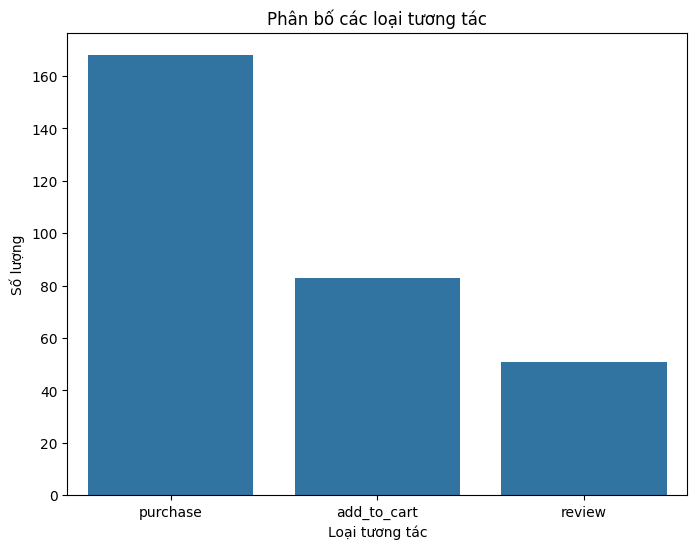

In [23]:
plt.figure(figsize=(8,6))
sns.countplot(x='interaction_type', data=user_item_df)
plt.title('Phân bố các loại tương tác')
plt.xlabel('Loại tương tác')
plt.ylabel('Số lượng')
plt.show()

3. Phân bố sản phẩm theo danh mục

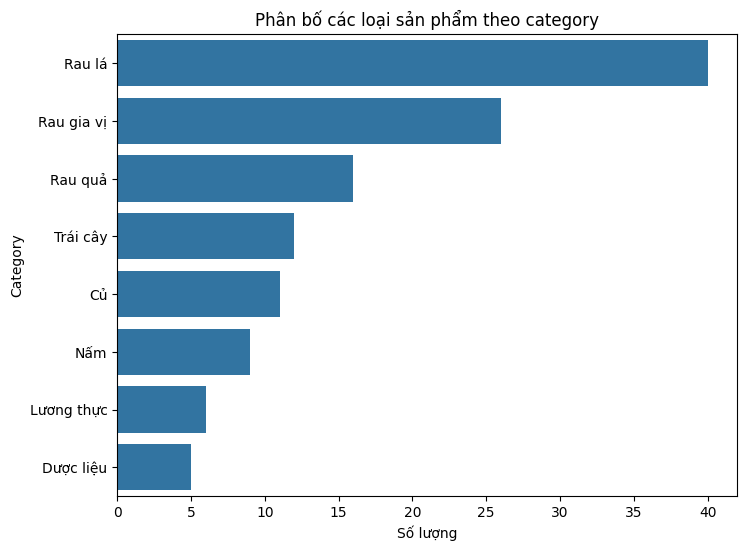

In [26]:
# biểu đồ phân loại sản phẩm theo category
plt.figure(figsize=(8,6))
sns.countplot(y='categoryname', data=product_content_df, order = product_content_df['categoryname'].value_counts().index)
plt.title('Phân bố các loại sản phẩm theo category')
plt.xlabel('Số lượng')
plt.ylabel('Category')
plt.show()

4. Phân bố sản phẩm theo farm

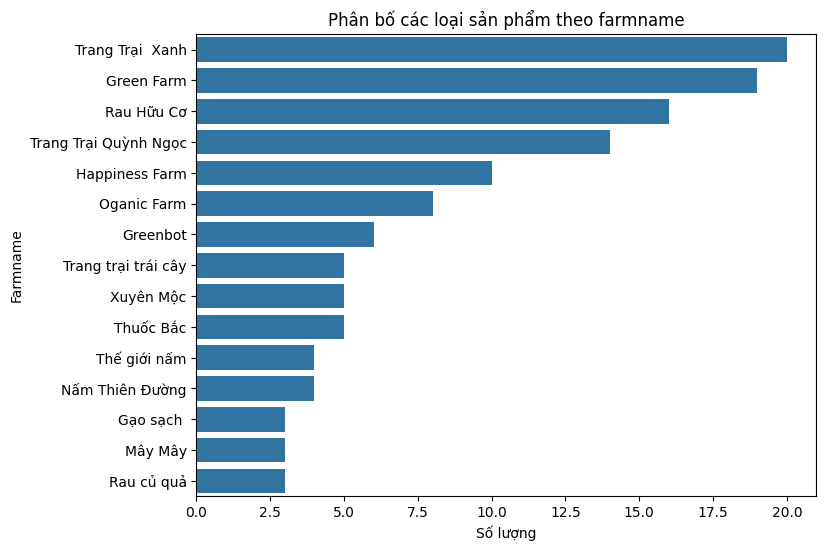

In [27]:
# biểu đồ phân loại sản phẩm theo farmname
plt.figure(figsize=(8,6))
sns.countplot(y='farmname', data=product_content_df, order = product_content_df['farmname'].value_counts().index)
plt.title('Phân bố các loại sản phẩm theo farmname')
plt.xlabel('Số lượng')
plt.ylabel('Farmname')
plt.show()


Xây dựng mô hình với Collaborative Filtering

1. Định nghĩa định dạng dữ liệu

In [5]:
reader = Reader(rating_scale=(1, 5))

2. Tạo dataset từ DataFrame

In [12]:
data = Dataset.load_from_df(user_item_df[['userid', 'productid', 'interaction_score']], reader)
data

3. Chia Dữ Liệu thành Train và Test

In [19]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

4. Khởi tạo mô hình SVD

In [20]:
svd_model = SVD()

5. Huấn luyện mô hình trên tập train

In [21]:
svd_model.fit(trainset)

6. Dự đoán trên tập test

In [22]:
predictions = svd_model.test(testset)


7. Tính RMSE và MAE

In [23]:
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.9633
MAE:  0.8157


8. Đánh giá mô hình bằng cross-validation

In [24]:
cv_results = cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
# cv_results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0127  0.9412  0.8975  0.8954  0.9819  0.9457  0.0462  
MAE (testset)     0.8703  0.8157  0.8012  0.7353  0.7946  0.8034  0.0432  
Fit time          0.01    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


9. Gợi ý với svd model vừa tạo được

In [25]:
# Goi y san pham cho nguoi dung
def recommend_cl_products(userid, n=10):
    # Lấy danh sách các sản phẩm duy nhất
    products = user_item_df['productid'].unique()
    
    # Tạo một mảng các sản phẩm, lặp lại cho mỗi người dùng
    products = np.array([products for _ in range(num_users)])
    products = products.flatten()
    
    # Tạo một mảng các sản phẩm, lặp lại n lần
    products = np.array([products for _ in range(n)])
    products = products.flatten()
    
    # Tạo một mảng các user_id, lặp lại cho mỗi sản phẩm
    users = np.array([userid for _ in range(num_products * n)])
    
    # Tạo testset với giá trị giả cho actual_rating (0)
    testset = list(zip(users, products, [0] * len(users)))
    
    # Dự đoán rating cho từng cặp (user_id, product_id)
    predictions = svd_model.test(testset)
    
    # Lấy giá trị dự đoán từ kết quả
    predictions = np.array([predictions[i][3] for i in range(len(predictions))])
    
    # Sắp xếp sản phẩm theo thứ tự giảm dần của rating dự đoán và lấy n sản phẩm đầu tiên
    recommended_products = products[np.argsort(-predictions)][:n]
    
    return recommended_products
  
# Gọi hàm recommend_products để lấy danh sách sản phẩm được gợi ý cho user có id là 16b94b68-3876-4b2e-a983-57c491b9e3de
print(recommend_cl_products('16b94b68-3876-4b2e-a983-57c491b9e3de', 10))

NameError: name 'num_users' is not defined

Xây Dựng Mô Hình Content-Based Filtering

1. Tạo cột 'content' bằng cách kết hợp các thuộc tính

In [28]:
product_content_df['content'] = (
                                product_content_df['productname'] + ' ' +
                                product_content_df['categoryname'] + ' ' + 
                                product_content_df['farmname'] + ' ' + 
                                product_content_df['farmprovince'])
product_content_df.head()

,productid,productname,categoryname,farmname,farmprovince,content
0,6116fdf3-473f-4324-af54-1b950076ef52,Xoài Cát,Trái cây,Trang trại trái cây,Quảng Nam,Xoài Cát Trái cây Trang trại trái cây Quảng Nam
1,b7237f07-c2bf-48d7-a630-3faaac02cfcc,Gạo ST25,Lương thực,Gạo sạch,Đồng Tháp,Gạo ST25 Lương thực Gạo sạch Đồng Tháp
2,b11d5edc-9b25-4eab-8f56-aae3476a7082,Rau cải ngồng,Rau lá,Happiness Farm,Dak Lak,Rau cải ngồng Rau lá Happiness Farm Dak Lak
3,95827b65-ec7b-405b-bd26-6558d04211cf,Gạo nếp,Lương thực,Gạo sạch,Đồng Tháp,Gạo nếp Lương thực Gạo sạch Đồng Tháp
4,5dedae03-b9c1-442e-aefe-6170e7a2aa6b,Rau muống,Rau lá,Trang Trại Xanh,Dak Lak,Rau muống Rau lá Trang Trại Xanh Dak Lak


2. Khởi tạo Vectorizer

In [29]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

3. Vector hóa nội dung

In [30]:
tfidf_matrix = tfidf.fit_transform(product_content_df['content'])
print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")

TF-IDF Matrix shape: (125, 367)


4. Tính Toán Similarity Giữa Các Sản Phẩm

In [31]:
# Tính cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Tạo Series mapping productid tới chỉ số trong DataFrame
indices = pd.Series(product_content_df.index, index=product_content_df['productid']).drop_duplicates()


productid
6116fdf3-473f-4324-af54-1b950076ef52    0
b7237f07-c2bf-48d7-a630-3faaac02cfcc    1
b11d5edc-9b25-4eab-8f56-aae3476a7082    2
95827b65-ec7b-405b-bd26-6558d04211cf    3
5dedae03-b9c1-442e-aefe-6170e7a2aa6b    4
dtype: int64

5. Hàm Gợi Ý Sản Phẩm Theo Content-Based Filtering

In [32]:
def get_content_based_recommendations(productid, cosine_sim=cosine_sim, indices=indices, product_content_df=product_content_df, top_n=10):
    if productid not in indices:
        return []
    
    idx = indices[productid]
    
    # Lấy cosine similarity của sản phẩm với tất cả các sản phẩm khác
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sắp xếp các sản phẩm dựa trên similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Lấy top_n sản phẩm tương tự (bỏ qua sản phẩm đầu tiên vì đó là chính nó)
    sim_scores = sim_scores[1:top_n+1]
    
    # Lấy chỉ số của các sản phẩm
    product_indices = [i[0] for i in sim_scores]
    
    # Trả về danh sách productid và productname của các sản phẩm tương tự
    return product_content_df[['productname', 'categoryname', 'farmname', 'farmprovince']].iloc[product_indices].to_dict('records')

In [33]:
get_content_based_recommendations('6116fdf3-473f-4324-af54-1b950076ef52')

[{'productname': 'Xoài Keo',
  'categoryname': 'Trái cây',
  'farmname': 'Trang trại trái cây',
  'farmprovince': 'Quảng Nam'},
 {'productname': 'Chuối Tiêu',
  'categoryname': 'Trái cây',
  'farmname': 'Trang trại trái cây',
  'farmprovince': 'Quảng Nam'},
 {'productname': 'Ổi Hồng',
  'categoryname': 'Trái cây',
  'farmname': 'Trang trại trái cây',
  'farmprovince': 'Quảng Nam'},
 {'productname': 'Mãng Cầu Xiêm',
  'categoryname': 'Trái cây',
  'farmname': 'Trang trại trái cây',
  'farmprovince': 'Quảng Nam'},
 {'productname': 'Cam Sành',
  'categoryname': 'Trái cây',
  'farmname': 'Trang Trại  Xanh',
  'farmprovince': 'Dak Lak'},
 {'productname': 'Xoài Keo',
  'categoryname': 'Trái cây',
  'farmname': 'Happiness Farm',
  'farmprovince': 'Dak Lak'},
 {'productname': 'Cam sành',
  'categoryname': 'Trái cây',
  'farmname': 'Green Farm',
  'farmprovince': 'Dak Lak'},
 {'productname': 'Nho Mỹ',
  'categoryname': 'Trái cây',
  'farmname': 'Green Farm',
  'farmprovince': 'Dak Lak'},
 {'pro

6. Đánh giá

Kết Hợp Collaborative Filtering và Content-Based Filtering

1. Chuẩn Hóa Điểm Số

In [24]:

pd.set_option('future.no_silent_downcasting', True)
# Chuẩn hóa điểm từ Collaborative Filtering
scaler = MinMaxScaler()

# Tạo DataFrame chứa các điểm từ Collaborative Filtering
users = user_item_df['userid'].unique()
# Lấy tất cả các user và product
products = product_content_df['productid'].unique()



In [25]:
print("Unique users:", users)

Unique users: ['f52e9e4e-33d1-4f86-819b-d9e52ff8cc77'
 '16b94b68-3876-4b2e-a983-57c491b9e3de'
 '85429147-f4d9-423b-9575-b515a4628bb1'
 '74fd76af-31b9-4741-bd1c-d5be331ee077'
 '096e2881-64b1-4d31-ab7a-d228ee1b356f'
 'b6d9c6af-51d5-4375-a75b-b6d84eedd1dd'
 '15c1a68f-154c-43bb-ba87-21b4f50ef3f6'
 '8bb833ea-4f3f-4dbf-a205-ecacb54d1f69'
 'ba95d332-7fc5-4272-9659-0e61f218d0b7'
 '2c1ce03f-9c6c-4bad-b5af-9b6970b41503'
 '31b9001c-75ef-4c85-92df-e8dfed4f6309'
 'a448f061-7b04-4d2f-90a8-5f9f6747d719'
 '4ce64499-e5fb-483e-b5d4-1ee83dacd87b'
 '482d17f2-55f2-44dd-a97d-7924b2dd9859'
 '8f58f0c0-ae6c-4db8-b7a5-01263659b22f'
 '7ac59731-821d-4b78-8581-6466f7599bbe'
 '6cf9592d-97a3-4a8b-8a1f-d7805e519c67'
 '3d520dee-6f76-4948-ac58-855ca44494e4'
 '49b80737-8f0a-463b-9a8b-c0f820ed5973'
 '0629010a-0505-4b2b-9c31-3b4704bd1a93'
 '426c7568-9d95-4da2-915c-9c2b77a375e7'
 '5f19c67c-6403-40d5-98e5-a9997848c92f'
 'e24876b4-883c-4c03-92db-392b751c5036'
 'fda88726-a110-4436-893e-5c6f1a9d1e8a'
 'ec924320-321f-4ace-845f-

In [26]:
print("Unique products:", products)

Unique products: ['6116fdf3-473f-4324-af54-1b950076ef52'
 'b7237f07-c2bf-48d7-a630-3faaac02cfcc'
 'b11d5edc-9b25-4eab-8f56-aae3476a7082'
 '95827b65-ec7b-405b-bd26-6558d04211cf'
 '5dedae03-b9c1-442e-aefe-6170e7a2aa6b'
 'ae4b4eee-886c-47fd-8bb2-6126dcb5f0ae'
 'ffcb432e-fc34-4881-adad-42e90f2d9fec'
 'f1aa0ac5-e531-4a37-9da8-c71367b8f203'
 '8c928aca-de9e-4d19-8915-fe4fb1c63ca7'
 'e78f8e7b-706a-4b3e-a137-16af136e81bf'
 'de77e80f-9035-4149-b2c0-be762d2012bf'
 '7322fc17-a36f-4391-8eb5-0a263c060d85'
 'fc3ec894-3b3e-480c-97e6-6f7e92029051'
 '217b798b-e613-45cb-9f8f-046b0bf61dff'
 'b1955c4b-f011-4fd3-b92e-a38a92955a50'
 '373419b8-b75b-4421-b6e5-6baf13a60918'
 '878be5be-7ef7-4912-b0a5-fd18f6cd4201'
 'cbf585bb-6a0e-4eb7-9c3b-e0b373028fcc'
 '3c59ef98-feae-442d-85f1-39285e665a17'
 '20955018-a13b-4e52-afd0-ede45b7a417f'
 '71694d49-0fd5-47f8-ba53-3ba5beb8ebce'
 '793e3062-fda8-4ebe-bec3-82c0e6e479f9'
 'f0bb7ae4-e6ef-4d01-95ae-4227920d52b3'
 '0bcba2bf-abd4-4f27-9703-a96c4def237a'
 '9bef9087-6d9c-4bd7-82

In [27]:
# Tạo DataFrame trống
collab_scores_df = pd.DataFrame(index=users, columns=products)
print("Initial collab_scores_df:", collab_scores_df)

Initial collab_scores_df:                                      6116fdf3-473f-4324-af54-1b950076ef52  \
f52e9e4e-33d1-4f86-819b-d9e52ff8cc77                                  NaN   
16b94b68-3876-4b2e-a983-57c491b9e3de                                  NaN   
85429147-f4d9-423b-9575-b515a4628bb1                                  NaN   
74fd76af-31b9-4741-bd1c-d5be331ee077                                  NaN   
096e2881-64b1-4d31-ab7a-d228ee1b356f                                  NaN   
b6d9c6af-51d5-4375-a75b-b6d84eedd1dd                                  NaN   
15c1a68f-154c-43bb-ba87-21b4f50ef3f6                                  NaN   
8bb833ea-4f3f-4dbf-a205-ecacb54d1f69                                  NaN   
ba95d332-7fc5-4272-9659-0e61f218d0b7                                  NaN   
2c1ce03f-9c6c-4bad-b5af-9b6970b41503                                  NaN   
31b9001c-75ef-4c85-92df-e8dfed4f6309                                  NaN   
a448f061-7b04-4d2f-90a8-5f9f6747d719              

In [28]:
# Dự đoán điểm cho mỗi cặp user-product
for user in users:
    user_ratings = user_item_df[user_item_df['userid'] == user]
    predictions = user_ratings.apply(
        lambda row: svd_model.predict(user, row['productid']).est, axis=1
    ).to_dict()
    collab_scores_df.loc[user] = predictions

print("Filled collab_scores_df:", collab_scores_df)

Filled collab_scores_df:                                      6116fdf3-473f-4324-af54-1b950076ef52  \
f52e9e4e-33d1-4f86-819b-d9e52ff8cc77                                  NaN   
16b94b68-3876-4b2e-a983-57c491b9e3de                                  NaN   
85429147-f4d9-423b-9575-b515a4628bb1                                  NaN   
74fd76af-31b9-4741-bd1c-d5be331ee077                                  NaN   
096e2881-64b1-4d31-ab7a-d228ee1b356f                                  NaN   
b6d9c6af-51d5-4375-a75b-b6d84eedd1dd                                  NaN   
15c1a68f-154c-43bb-ba87-21b4f50ef3f6                                  NaN   
8bb833ea-4f3f-4dbf-a205-ecacb54d1f69                                  NaN   
ba95d332-7fc5-4272-9659-0e61f218d0b7                                  NaN   
2c1ce03f-9c6c-4bad-b5af-9b6970b41503                                  NaN   
31b9001c-75ef-4c85-92df-e8dfed4f6309                                  NaN   
a448f061-7b04-4d2f-90a8-5f9f6747d719               

In [29]:
# Điền giá trị thiếu bằng 0
collab_scores_df = collab_scores_df.fillna(0)

# Chuẩn hóa điểm
collab_scores_scaled = pd.DataFrame(scaler.fit_transform(collab_scores_df), 
                                    index=collab_scores_df.index, 
                                    columns=collab_scores_df.columns)

# Tạo similarity matrix cho Content-Based Filtering
content_scores = pd.DataFrame(cosine_sim, index=product_content_df['productid'], columns=product_content_df['productid'])
print("Content scores matrix:", content_scores)

Content scores matrix: productid                             6116fdf3-473f-4324-af54-1b950076ef52  \
productid                                                                    
6116fdf3-473f-4324-af54-1b950076ef52                              1.000000   
b7237f07-c2bf-48d7-a630-3faaac02cfcc                              0.000000   
b11d5edc-9b25-4eab-8f56-aae3476a7082                              0.000000   
95827b65-ec7b-405b-bd26-6558d04211cf                              0.000000   
5dedae03-b9c1-442e-aefe-6170e7a2aa6b                              0.069767   
...                                                                    ...   
85099c1a-c83e-4776-a44e-1344e28c93f9                              0.000000   
891ad178-c9b5-45f7-889b-ea8fe3fdcb75                              0.000000   
42610d29-5882-4d8c-8339-e2eee4fd46e7                              0.000000   
5f267152-e153-4d48-abff-346267a5c9cc                              0.000000   
b729d242-4987-4c56-882d-d42f2acd5907     

In [30]:
# Tính điểm Content-Based cho mỗi user
user_content_scores = pd.DataFrame(index=users, columns=products)

for user in users:
    interacted_products = user_item_df[user_item_df['userid'] == user]['productid'].unique()
    if len(interacted_products) == 0:
        user_content_scores.loc[user] = 0
    else:
        valid_interacted_products = [product for product in interacted_products if product in content_scores.index]
    
        if len(valid_interacted_products) == 0:
            user_content_scores.loc[user] = 0
        else:
            sim_matrix = content_scores[valid_interacted_products]
            user_content_scores.loc[user] = sim_matrix.mean(axis=0)

print("User content scores:", user_content_scores)

User content scores:                                      6116fdf3-473f-4324-af54-1b950076ef52  \
f52e9e4e-33d1-4f86-819b-d9e52ff8cc77                                    0   
16b94b68-3876-4b2e-a983-57c491b9e3de                                  NaN   
85429147-f4d9-423b-9575-b515a4628bb1                                  NaN   
74fd76af-31b9-4741-bd1c-d5be331ee077                                  NaN   
096e2881-64b1-4d31-ab7a-d228ee1b356f                                  NaN   
b6d9c6af-51d5-4375-a75b-b6d84eedd1dd                                  NaN   
15c1a68f-154c-43bb-ba87-21b4f50ef3f6                             0.067323   
8bb833ea-4f3f-4dbf-a205-ecacb54d1f69                                  NaN   
ba95d332-7fc5-4272-9659-0e61f218d0b7                                  NaN   
2c1ce03f-9c6c-4bad-b5af-9b6970b41503                                  NaN   
31b9001c-75ef-4c85-92df-e8dfed4f6309                                  NaN   
a448f061-7b04-4d2f-90a8-5f9f6747d719                   

In [31]:
# Điền giá trị thiếu bằng 0 và chuẩn hóa
user_content_scores_scaled = pd.DataFrame(scaler.fit_transform(user_content_scores.fillna(0)), 
                                            index=user_content_scores.index, 
                                            columns=user_content_scores.columns)

# Tạo hybrid score bằng cách trung bình có trọng số (ví dụ: 0.6 từ CF và 0.4 từ CBF)
hybrid_scores = 0.6 * collab_scores_scaled + 0.4 * user_content_scores_scaled

# Reset the index to make 'userid' a column
hybrid_scores_reset = hybrid_scores.reset_index()
hybrid_scores_reset.rename(columns={'index': 'userid'}, inplace=True)

# Tạo DataFrame dài cho hybrid recommendations
hybrid_recommendations = hybrid_scores_reset.melt(id_vars='userid', var_name='productid', value_name='hybrid_score')

# Lọc các điểm không cần thiết (ví dụ: hybrid_score > 0)
hybrid_recommendations = hybrid_recommendations[hybrid_recommendations['hybrid_score'] > 0]

# Sắp xếp các gợi ý cho mỗi user theo hybrid_score giảm dần
hybrid_recommendations = hybrid_recommendations.sort_values(['userid', 'hybrid_score'], ascending=[True, False])

# Lấy top N gợi ý cho mỗi user (ví dụ: top 10)
top_n = 50
hybrid_recommendations = hybrid_recommendations.groupby('userid').head(top_n)

print(hybrid_recommendations.head())

                                    userid  \
142   0629010a-0505-4b2b-9c31-3b4704bd1a93   
906   096e2881-64b1-4d31-ab7a-d228ee1b356f   
2095  096e2881-64b1-4d31-ab7a-d228ee1b356f   
45    096e2881-64b1-4d31-ab7a-d228ee1b356f   
30    0d22b583-2791-4166-aef4-d0573f42572a   

                                 productid  hybrid_score  
142   95827b65-ec7b-405b-bd26-6558d04211cf           0.4  
906   f0bb7ae4-e6ef-4d01-95ae-4227920d52b3           0.4  
2095  bfa825ec-c0dc-4cb7-8e71-e56351a93406           0.4  
45    b7237f07-c2bf-48d7-a630-3faaac02cfcc           0.4  
30    6116fdf3-473f-4324-af54-1b950076ef52           0.4  


Tạo Gợi Ý Cuối Cùng cho Người Dùng

In [32]:
# Merge hybrid score với thông tin sản phẩm
hybrid_recommendations = hybrid_recommendations.merge(product_content_df, on='productid')

# Chuyển đổi thành danh sách dict hoặc các cấu trúc dữ liệu phù hợp để sử dụng trong hệ thống
recommendations_list = hybrid_recommendations.to_dict(orient='records')

# Ví dụ: Gợi ý cho một người dùng cụ thể
user_id = '16b94b68-3876-4b2e-a983-57c491b9e3de'
user_recommendations = hybrid_recommendations[hybrid_recommendations['userid'] == user_id].sort_values(by='hybrid_score', ascending=False).head(top_n)

display(user_recommendations)

,userid,productid,hybrid_score,productname,categoryname,farmname,farmprovince,content
13,16b94b68-3876-4b2e-a983-57c491b9e3de,cbf585bb-6a0e-4eb7-9c3b-e0b373028fcc,0.4,Cải ngọt,Rau lá,Green Farm,Dak Lak,Cải ngọt Rau lá Green Farm Dak Lak
14,16b94b68-3876-4b2e-a983-57c491b9e3de,f0bb7ae4-e6ef-4d01-95ae-4227920d52b3,0.4,Dưa Chuột,Rau quả,Trang Trại Xanh,Dak Lak,Dưa Chuột Rau quả Trang Trại Xanh Dak Lak
15,16b94b68-3876-4b2e-a983-57c491b9e3de,063c670e-811e-4b5a-93ff-89c1af30ef33,0.4,Bí Xanh,Rau quả,Xuyên Mộc,BRVT,Bí Xanh Rau quả Xuyên Mộc BRVT
16,16b94b68-3876-4b2e-a983-57c491b9e3de,edeb67be-7462-4217-933a-328ca1ce611a,0.4,Cải Bẹ Xanh,Rau lá,Trang Trại Xanh,Dak Lak,Cải Bẹ Xanh Rau lá Trang Trại Xanh Dak Lak
17,16b94b68-3876-4b2e-a983-57c491b9e3de,bfa825ec-c0dc-4cb7-8e71-e56351a93406,0.4,Rau mồng tơi,Rau lá,Trang Trại Xanh,Dak Lak,Rau mồng tơi Rau lá Trang Trại Xanh Dak Lak


Xử Lý Vấn Đề Cold Start cho Người Dùng Mới

1. Tính toán số lần tương tác (purchase, add_to_cart, review) cho mỗi sản phẩm

In [33]:
product_popularity = user_item_df.groupby('productid')['interaction_score'].sum().reset_index()
product_popularity = product_popularity.sort_values(by='interaction_score', ascending=False)

2. Lấy top N sản phẩm phổ biến

In [34]:
top_n_popular = 15
popular_products = product_popularity['productid'].head(top_n_popular).tolist()

print(f"\nTop {top_n_popular} sản phẩm phổ biến:")
print(popular_products)


Top 15 sản phẩm phổ biến:
['3602d3ba-de59-468b-8ef9-a506720d2a2c', 'b7237f07-c2bf-48d7-a630-3faaac02cfcc', '92430556-f657-482e-b4f3-f1efe31fc1f1', '6116fdf3-473f-4324-af54-1b950076ef52', 'ffcb432e-fc34-4881-adad-42e90f2d9fec', 'cbf585bb-6a0e-4eb7-9c3b-e0b373028fcc', '3c59ef98-feae-442d-85f1-39285e665a17', '373419b8-b75b-4421-b6e5-6baf13a60918', '7148f50f-8161-499d-8447-25a280ca2bbd', 'fd969e1f-612d-436e-b159-cb66e30d8b42', '95827b65-ec7b-405b-bd26-6558d04211cf', 'bfa825ec-c0dc-4cb7-8e71-e56351a93406', '063c670e-811e-4b5a-93ff-89c1af30ef33', 'fc3ec894-3b3e-480c-97e6-6f7e92029051', 'ae4b4eee-886c-47fd-8bb2-6126dcb5f0ae']


In [35]:
popular_recommendations = product_content_df[product_content_df['productid'].isin(popular_products)]

print("\nThông tin các sản phẩm phổ biến:")
display(popular_recommendations)


Thông tin các sản phẩm phổ biến:


,productid,productname,categoryname,farmname,farmprovince,content
0,6116fdf3-473f-4324-af54-1b950076ef52,Xoài Cát,Trái cây,Trang trại trái cây,Quảng Nam,Xoài Cát Trái cây Trang trại trái cây Quảng Nam
1,b7237f07-c2bf-48d7-a630-3faaac02cfcc,Gạo ST25,Lương thực,Gạo sạch,Đồng Tháp,Gạo ST25 Lương thực Gạo sạch Đồng Tháp
3,95827b65-ec7b-405b-bd26-6558d04211cf,Gạo nếp,Lương thực,Gạo sạch,Đồng Tháp,Gạo nếp Lương thực Gạo sạch Đồng Tháp
5,ae4b4eee-886c-47fd-8bb2-6126dcb5f0ae,Rau ngót,Rau lá,Trang Trại Quỳnh Ngọc,Dak Lak,Rau ngót Rau lá Trang Trại Quỳnh Ngọc Dak Lak
6,ffcb432e-fc34-4881-adad-42e90f2d9fec,Chuối Tiêu,Trái cây,Trang trại trái cây,Quảng Nam,Chuối Tiêu Trái cây Trang trại trái cây Quảng Nam
12,fc3ec894-3b3e-480c-97e6-6f7e92029051,Cam Sành,Trái cây,Trang Trại Xanh,Dak Lak,Cam Sành Trái cây Trang Trại Xanh Dak Lak
15,373419b8-b75b-4421-b6e5-6baf13a60918,Bắp Mỹ,Lương thực,Mây Mây,Đắk Lăk,Bắp Mỹ Lương thực Mây Mây Đắk Lăk
17,cbf585bb-6a0e-4eb7-9c3b-e0b373028fcc,Cải ngọt,Rau lá,Green Farm,Dak Lak,Cải ngọt Rau lá Green Farm Dak Lak
18,3c59ef98-feae-442d-85f1-39285e665a17,Nho Mỹ,Trái cây,Green Farm,Dak Lak,Nho Mỹ Trái cây Green Farm Dak Lak
46,063c670e-811e-4b5a-93ff-89c1af30ef33,Bí Xanh,Rau quả,Xuyên Mộc,BRVT,Bí Xanh Rau quả Xuyên Mộc BRVT


Gợi Ý Sản Phẩm Dựa trên Content-Based Filtering cho Người Dùng Mới

In [36]:
def recommend_for_new_user(content_scores, product_content_df, top_n=15):
    # Lấy điểm similarity trung bình cho tất cả các sản phẩm
    avg_content_scores = content_scores.mean(axis=1)
    
    # Sắp xếp các sản phẩm theo điểm similarity giảm dần
    avg_content_scores_sorted = avg_content_scores.sort_values(ascending=False)
    
    # Lấy top N sản phẩm
    top_products = avg_content_scores_sorted.head(top_n).index.tolist()
    
    # Lấy thông tin sản phẩm từ product_content_df
    recommendations = product_content_df[product_content_df['productid'].isin(top_products)]
    
    return recommendations

# Gợi ý cho người dùng mới
new_user_recommendations = recommend_for_new_user(content_scores, product_content_df, top_n=10)

print("\nGợi ý cho người dùng mới (dựa trên Content-Based Filtering):")
display(new_user_recommendations)


Gợi ý cho người dùng mới (dựa trên Content-Based Filtering):


,productid,productname,categoryname,farmname,farmprovince,content
4,5dedae03-b9c1-442e-aefe-6170e7a2aa6b,Rau muống,Rau lá,Trang Trại Xanh,Dak Lak,Rau muống Rau lá Trang Trại Xanh Dak Lak
10,de77e80f-9035-4149-b2c0-be762d2012bf,Hành lá,Rau gia vị,Trang Trại Xanh,Dak Lak,Hành lá Rau gia vị Trang Trại Xanh Dak Lak
43,301d330c-7c93-4d98-afe6-f495b8f38552,Rau húng quế,Rau gia vị,Trang Trại Xanh,Dak Lak,Rau húng quế Rau gia vị Trang Trại Xanh Dak Lak
50,edeb67be-7462-4217-933a-328ca1ce611a,Cải Bẹ Xanh,Rau lá,Trang Trại Xanh,Dak Lak,Cải Bẹ Xanh Rau lá Trang Trại Xanh Dak Lak
51,bfa825ec-c0dc-4cb7-8e71-e56351a93406,Rau mồng tơi,Rau lá,Trang Trại Xanh,Dak Lak,Rau mồng tơi Rau lá Trang Trại Xanh Dak Lak
64,a5612187-6268-4a5a-8d31-5b03e1c73e49,Cải Bẹ Xanh,Rau lá,Trang Trại Quỳnh Ngọc,Dak Lak,Cải Bẹ Xanh Rau lá Trang Trại Quỳnh Ngọc Dak Lak
82,a3ef4a9b-0c76-48c0-95da-dfb895bcfce8,Rau dền xanh,Rau lá,Trang Trại Xanh,Dak Lak,Rau dền xanh Rau lá Trang Trại Xanh Dak Lak
83,c38eadaf-8424-4f27-bb49-3f838ca26f28,Rau nhút,Rau lá,Trang Trại Xanh,Dak Lak,Rau nhút Rau lá Trang Trại Xanh Dak Lak
97,2e48b0ca-29be-4331-a7f6-ec7713488af2,Rau dền xanh,Rau lá,Trang Trại Quỳnh Ngọc,Dak Lak,Rau dền xanh Rau lá Trang Trại Quỳnh Ngọc Dak Lak
98,5e382b17-bec6-4816-9b46-985e78971b6d,Hành lá,Rau gia vị,Trang Trại Quỳnh Ngọc,Dak Lak,Hành lá Rau gia vị Trang Trại Quỳnh Ngọc Dak Lak


Lưu mô hình

In [37]:
import pickle

# Lưu mô hình SVD
with open('svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)

# Lưu TF-IDF Vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Lưu cosine similarity matrix
with open('cosine_similarity.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)


Đánh giá mô hình

1. Precision@K và Recall@K

In [34]:
from sklearn.metrics import precision_score, recall_score

def precision_at_k(recommended_items, relevant_items, k):
    recommended_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    recommended_set = set(recommended_k)
    return len(recommended_set & relevant_set) / k

def recall_at_k(recommended_items, relevant_items, k):
    recommended_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    recommended_set = set(recommended_k)
    return len(recommended_set & relevant_set) / len(relevant_set) if len(relevant_set) > 0 else 0

# Ví dụ tính Precision@5 và Recall@5 cho một người dùng
recommended_items = get_content_based_recommendations('p1')  # Thay bằng danh sách gợi ý thực tế
relevant_items = ['p2', 'p3', 'p4']  # Danh sách sản phẩm thực sự phù hợp

precision = precision_at_k(recommended_items, relevant_items, k=5)
recall = recall_at_k(recommended_items, relevant_items, k=5)

print(f"Precision@5: {precision}")
print(f"Recall@5: {recall}")


Precision@5: 0.0
Recall@5: 0.0


Mean Average Precision (MAP) và Normalized Discounted Cumulative Gain (NDCG)

In [36]:
from sklearn.metrics import ndcg_score

def average_precision(recommended_items, relevant_items, k):
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(recommended_items[:k]):
        if p in relevant_items and p not in recommended_items[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    if not relevant_items:
        return 0.0
    return score / min(len(relevant_items), k)

def ndcg_at_k(recommended_items, relevant_items, k):
    y_true = [1 if item in relevant_items else 0 for item in recommended_items[:k]]
    y_score = [1] * len(y_true)  # Giả định rằng các sản phẩm được gợi ý đều là liên quan
    return ndcg_score([y_true], [y_score])

# Ví dụ tính MAP@5 và NDCG@5 cho một người dùng
map_score = average_precision(recommended_items, relevant_items, k=5)
ndcg = ndcg_at_k(recommended_items, relevant_items, k=5)

print(f"MAP@5: {map_score}")
print(f"NDCG@5: {ndcg}")


ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.

In [38]:
true_labels = user_item_df[user_item_df['userid'] == user_id]['productid'].unique();
pred_labels = hybrid_recommendations[hybrid_recommendations['userid'] == user_id]['productid'].values;

NameError: name 'user_id' is not defined

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Giả định: true_labels là danh sách các sản phẩm mà user đã tương tác trước đó
# pred_labels là danh sách các sản phẩm mà mô hình gợi ý

def evaluate_content_based(true_labels, pred_labels):
    # Precision
    precision = precision_score(true_labels, pred_labels, average='binary')
    
    # Recall
    recall = recall_score(true_labels, pred_labels, average='binary')
    
    # F1-score
    f1 = f1_score(true_labels, pred_labels, average='binary')
    
    return precision, recall, f1

# Giả định true_labels và pred_labels đã được xác định
precision, recall, f1 = evaluate_content_based(true_labels, pred_labels)

print(f"Content-Based Filtering Evaluation:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")